In [1]:
#downloading files
!wget http://images.cocodataset.org/zips/train2017.zip -O coco_train2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip -O coco_val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O coco_ann2017.zip

--2024-10-12 17:14:40--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.234.161, 3.5.8.15, 3.5.3.75, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.234.161|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘coco_train2017.zip’

coco_train2017.zip  100%[===================>]  18.01G   115MB/s    in 3m 14s  

2024-10-12 17:17:55 (94.9 MB/s) - ‘coco_train2017.zip’ saved [19336861798/19336861798]

--2024-10-12 17:17:55--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.169.57, 52.217.86.60, 3.5.28.131, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.169.57|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘coco_val2017.zip’

coco_val2017.zip    100%[===================

In [2]:
#unzip files
from zipfile import ZipFile, BadZipFile
import os

def extract_zip_file(extract_path):
    try:
        with ZipFile(extract_path+".zip") as zfile:
            zfile.extractall(extract_path)

        # remove zipfile
        zfileTOremove=f"{extract_path}"+".zip"
        if os.path.isfile(zfileTOremove):
            os.remove(zfileTOremove)
        else:
            print("Error: %s file not found" % zfileTOremove)

    except BadZipFile as e:
        print("Error:", e)


extract_train_path = "./coco_train2017"
extract_val_path = "./coco_val2017"
extract_ann_path="./coco_ann2017"

extract_zip_file(extract_train_path)
extract_zip_file(extract_val_path)
extract_zip_file(extract_ann_path)

In [3]:
#importing libraries
import torch
import torchvision
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import os

In [4]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 133MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [5]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter',
    'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe',
    'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle',
    'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
    'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
    'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
    'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
    'hair drier', 'toothbrush'
]

In [6]:
def predict_image(image_path, model, threshold=0.5):
    image = Image.open(image_path).convert("RGB")
    image_tensor = F.to_tensor(image)

    with torch.no_grad():
        predictions = model([image_tensor])

    boxes = predictions[0]['boxes'].cpu().numpy()
    labels = predictions[0]['labels'].cpu().numpy()
    scores = predictions[0]['scores'].cpu().numpy()

    filtered_boxes = boxes[scores >= threshold]
    filtered_labels = labels[scores >= threshold]

    image_array = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    for i, box in enumerate(filtered_boxes):
        label = COCO_INSTANCE_CATEGORY_NAMES[filtered_labels[i]]
        cv2.rectangle(image_array, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255, 0, 0), 2)
        cv2.putText(image_array, label, (int(box[0]), int(box[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
    plt.imshow(image_array)
    plt.axis("off")
    plt.show()

In [7]:
def detect_objects_in_dataset(image_folder):
    images = [os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith(('.jpg', '.png', '.jpeg'))]

    for image_path in images:
        print(f"Predicting for image: {image_path}")
        predict_image(image_path, model)

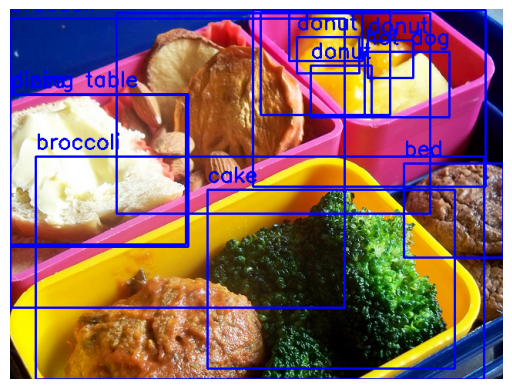

In [10]:
image_path = "/content/coco_train2017/train2017/000000000009.jpg"
predict_image(image_path, model)

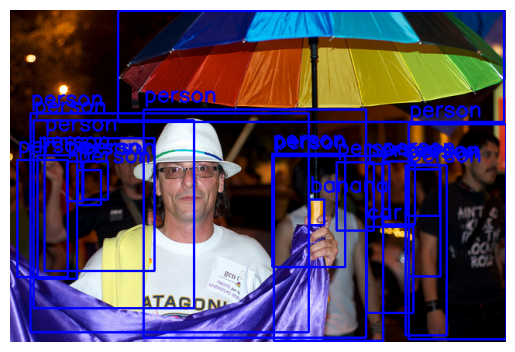

In [14]:
image_path = "/content/coco_train2017/train2017/000000003272.jpg"
predict_image(image_path, model)

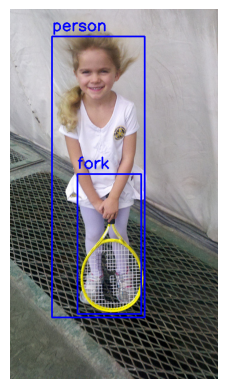

In [16]:
image_path = "/content/coco_val2017/val2017/000000117744.jpg"
predict_image(image_path, model)

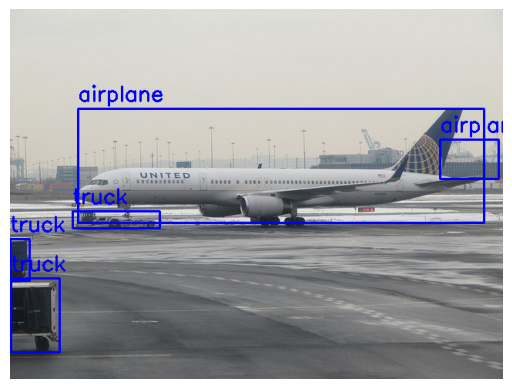

In [21]:
image_path = "/content/coco_val2017/val2017/000000098520.jpg"
predict_image(image_path, model)

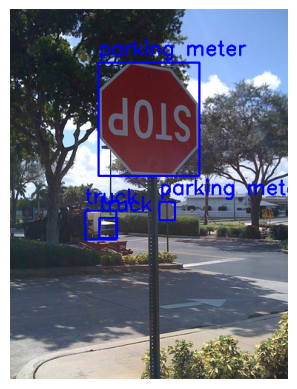

In [25]:
image_path = "/content/coco_val2017/val2017/000000000724.jpg"
predict_image(image_path, model)

In [47]:
#Environment Setup

!pip install torch torchvision
!pip install pycocotools
import requests

In [44]:
#Loading Pre-trained Model

import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# Load a pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()  # Set the model to evaluation mode

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [45]:
#Preparing the Dataset

from pycocotools.coco import COCO
from torchvision.transforms import functional as F

# Load COCO dataset
coco = COCO('/content/coco_ann2017/annotations/instances_train2017.json')
image_ids = coco.getImgIds()

def get_image_and_annotations(image_id):
    img_info = coco.loadImgs(image_id)[0]
    img = Image.open(requests.get(img_info['coco_url'], stream=True).raw)
    annotations = coco.loadAnns(coco.getAnnIds(img_id=image_id))
    return img, annotations

loading annotations into memory...
Done (t=27.81s)
creating index...
index created!


In [55]:
#Fine-tuning the Model

import requests  # Importing requests to fetch images

def get_image_and_annotations(image_id):
    img_info = coco.loadImgs(image_id)[0]
    img = Image.open(requests.get(img_info['coco_url'], stream=True).raw)

    #  retrieving annotation IDs
    ann_ids = coco.getAnnIds(imgIds=image_id)
    annotations = coco.loadAnns(ann_ids)

    return img, annotations



In [62]:
import torchvision.transforms as T

# Define transformations
transform = T.Compose([T.ToTensor()])

# Training loop
for epoch in range(num_epochs):
    for image_id in image_ids:
        img, annotations = get_image_and_annotations(image_id)
        img_tensor = transform(img)

        # Prepare targets
        target = {'boxes': [], 'labels': []}
        for ann in annotations:
            bbox = ann['bbox']  # [x_min, y_min, width, height]
            x_min, y_min, width, height = bbox

            # Calculate x_max and y_max
            x_max = x_min + width
            y_max = y_min + height

            # Checking for valid bounding box
            if width > 0 and height > 0:
                target['boxes'].append([x_min, y_min, x_max, y_max])
                target['labels'].append(ann['category_id'])

        if len(target['boxes']) == 0:
            continue

        target['boxes'] = torch.tensor(target['boxes'], dtype=torch.float32)
        target['labels'] = torch.tensor(target['labels'], dtype=torch.int64)


        # Forward pass
        loss_dict = model([img_tensor], [target])

        # Check if loss_dict is a list
        if isinstance(loss_dict, list):

        # Handle case where loss_dict is unexpectedly a list
          print("Unexpected output format from model:", loss_dict)



          losses = sum(loss for loss in loss_dict.values())

        # Backward pass and optimization step
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

Unexpected output format from model: [{'boxes': tensor([[347.8893,  21.5560, 480.0002, 311.2990],
        [357.5391, 167.2558, 477.4699, 336.7010],
        [473.4106, 172.3068, 513.0092, 219.6692],
        [486.4957, 188.7783, 513.1275, 220.1988],
        [472.6267, 172.7913, 492.4813, 221.6167],
        [394.5110, 139.9073, 447.0159, 193.4553],
        [385.5820, 191.5250, 447.2959, 230.5063],
        [389.0957, 132.7467, 453.1421, 193.9193],
        [487.7064, 193.8685, 503.8741, 218.8717],
        [476.3423, 186.0595, 512.1722, 219.7638],
        [502.5644, 175.0320, 517.8199, 191.4457],
        [386.9508, 191.8381, 447.2097, 231.5348],
        [406.9619, 103.6795, 494.6678, 323.1700],
        [443.0569, 160.5188, 496.8850, 321.5056],
        [338.9709, 193.4790, 356.6578, 207.0273],
        [488.8894, 188.2364, 508.9844, 218.0139],
        [334.3667, 115.8068, 517.0187, 339.1917],
        [470.7717, 174.0531, 483.1581, 225.3704],
        [473.6021, 204.7536, 488.7565, 220.9334],
  

AttributeError: 'list' object has no attribute 'values'

In [63]:
#print loss_dict to handle error
print("Model output:", loss_dict)

Model output: [{'boxes': tensor([[347.8893,  21.5560, 480.0002, 311.2990],
        [357.5391, 167.2558, 477.4699, 336.7010],
        [473.4106, 172.3068, 513.0092, 219.6692],
        [486.4957, 188.7783, 513.1275, 220.1988],
        [472.6267, 172.7913, 492.4813, 221.6167],
        [394.5110, 139.9073, 447.0159, 193.4553],
        [385.5820, 191.5250, 447.2959, 230.5063],
        [389.0957, 132.7467, 453.1421, 193.9193],
        [487.7064, 193.8685, 503.8741, 218.8717],
        [476.3423, 186.0595, 512.1722, 219.7638],
        [502.5644, 175.0320, 517.8199, 191.4457],
        [386.9508, 191.8381, 447.2097, 231.5348],
        [406.9619, 103.6795, 494.6678, 323.1700],
        [443.0569, 160.5188, 496.8850, 321.5056],
        [338.9709, 193.4790, 356.6578, 207.0273],
        [488.8894, 188.2364, 508.9844, 218.0139],
        [334.3667, 115.8068, 517.0187, 339.1917],
        [470.7717, 174.0531, 483.1581, 225.3704],
        [473.6021, 204.7536, 488.7565, 220.9334],
        [489.7663, 173.71

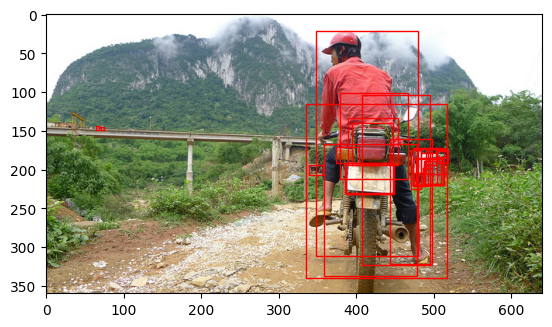

In [64]:
#Sample Predictions with Bounding Boxes

import matplotlib.pyplot as plt

# Making predictions on a sample image
model.eval()
with torch.no_grad():
    prediction = model([img_tensor])

# Visualizing results
plt.imshow(img)
for box in prediction[0]['boxes']:
    plt.gca().add_patch(plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], fill=False, color='red'))
plt.show()

In [73]:
#Evaluation Metrics (mAP)

import numpy as np
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# Assuming 'coco' is  COCO object with ground truth annotations
# Creating a list of COCO-style predictions
coco_predictions = []
for img_id, pred in zip(image_ids, prediction):
    boxes = pred['boxes'].cpu().numpy()  # Convert to numpy array
    scores = pred['scores'].cpu().numpy()
    labels = pred['labels'].cpu().numpy()

    for box, score, label in zip(boxes, scores, labels):
        if score > 0.5:  # Confidence threshold
            coco_predictions.append({
                'image_id': img_id,
                'category_id': label,
                'bbox': [box[0], box[1], box[2] - box[0], box[3] - box[1]],  # Convert to [x,y,width,height]
                'score': score.item()   # Convert to float
            })

# coco_predictions is a list of dictionaries
print("Formatted Predictions:", coco_predictions)



Formatted Predictions: [{'image_id': 391895, 'category_id': 1, 'bbox': [347.88928, 21.556011, 132.11096, 289.74304], 'score': 0.9944689273834229}, {'image_id': 391895, 'category_id': 4, 'bbox': [357.5391, 167.25583, 119.93085, 169.44522], 'score': 0.988309383392334}, {'image_id': 391895, 'category_id': 1, 'bbox': [473.4106, 172.30681, 39.59854, 47.362427], 'score': 0.9670838117599487}, {'image_id': 391895, 'category_id': 2, 'bbox': [486.49567, 188.77829, 26.631836, 31.420547], 'score': 0.8124117851257324}, {'image_id': 391895, 'category_id': 1, 'bbox': [472.62674, 172.7913, 19.854523, 48.825424], 'score': 0.7611717581748962}]
